----
# Anomaly Detection in Time Series analysis
----

## Anomaly Detection with Seasonal-Trend Decomposition (STL)

In this example we are going to detect anomalies in time series data using LOESS in Seasonal-Trend Decomposition. More theory in the notes.

In [52]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from datetime import datetime

First we load the data. In this project we are going to use the search interest data of the word "snowman" from Google Trends. The search interest is a value indicating the searching volume of a word, relative to the maximum historical volume of the searches for that world. The data is from the whole world starting from 2004 and ending 2021.

In [23]:
data = pd.read_csv("../data/snowman_google.csv")
data = data.set_index("Month")
data.index = pd.to_datetime(data.index)
data.describe()

,Interest
count,216.000000
mean,16.708333
std,18.447238
min,3.000000
25%,5.000000
50%,9.000000
75%,19.000000
max,100.000000


Let's first plot the data so we get a better grasp on what we are working.

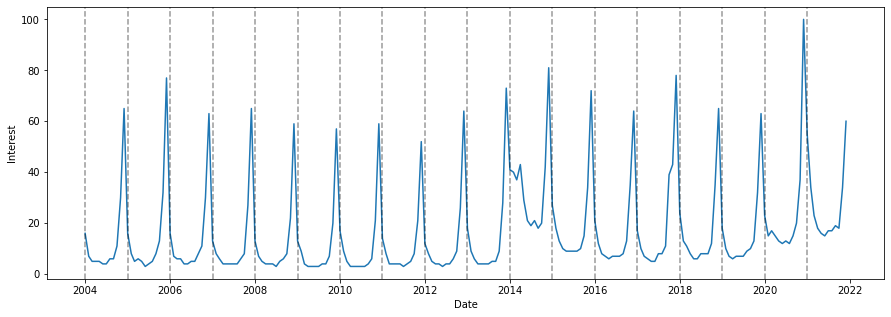

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(data);
for year in data.index.year.unique():
    plt.axvline(datetime(year, 1, 1), color="k", ls="--", alpha=0.4)
plt.xlabel("Date")
plt.ylabel("Interest");

From the visualization we can see that the interest on the word snowman is peaking each year around christmas, which makes sense. From the graph we can also see that there seems to be an anomaly in 2014 spring or early summer. Also the peak for 2020 is quite high compared to other years, so there might be something unusual there too. Therefore, there are two anomalies in the graph that we can see:
1. 2014 Spring
2. 2020 Christmas

After visual inspection we can move to the STL decomposition to try to find these anomalies. 

In [34]:
stl = STL(data)
fit = stl.fit()

STL decomposition decomposes a time series into three components: seasonal part, trend part and the residual part. The STL class in statsmodels uses LOESS (locally estimated scatterplot smoothing) to extract these estimates. We can now plot these different parts.

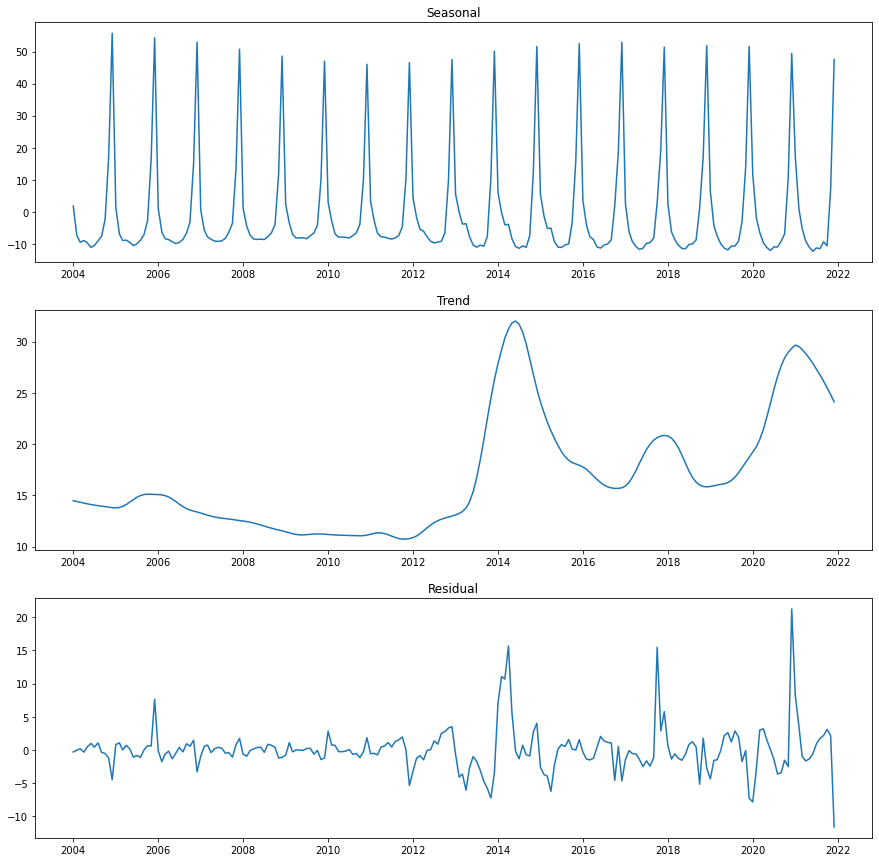

In [44]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(15, 15)
ax[0].plot(fit.seasonal)
ax[0].set_title("Seasonal")

ax[1].plot(fit.trend)
ax[1].set_title("Trend")

ax[2].plot(fit.resid)
ax[2].set_title("Residual");

Now we can also compare the original graph with a new graph that is formed from the seasonal part and the trend part.

Text(0.5, 1.0, 'Original Time Series vs. Estimated')

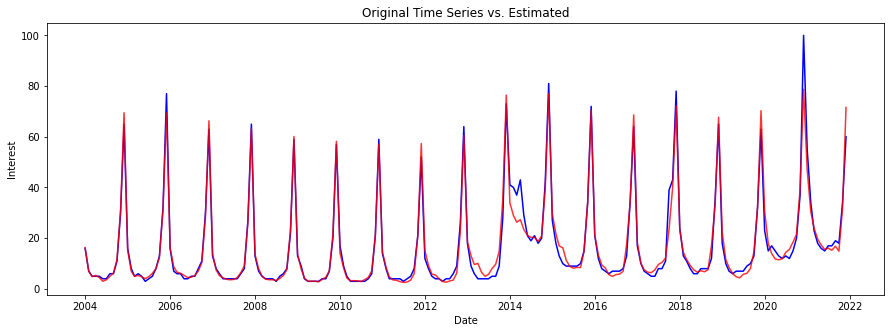

In [50]:
new_ts = fit.seasonal + fit.trend

plt.figure(figsize=(15, 5))
plt.plot(data, color="blue")
plt.plot(new_ts, color="red", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Interest")
plt.title("Original Time Series vs. Estimated")

From this visualisation we can see that the red time series, which does not contain the residuals, differs from the original (blue) in multiple places including 2014 spring and 2020 christmas. However, there are also other parts where the graphs differ and therefore we must apply some algorithm to see which is an anomaly and which is not. This can be done for example by using the residual data we have extracted in the STL. We decide to use the Interquantile Range (more on notes) to find the residuals that are anomalies so now machine learning is needed.

In [77]:
mean_res = fit.resid.mean()
std_res = fit.resid.std()
q1 = np.percentile(fit.resid, 25)
q3 = np.percentile(fit.resid, 75)
iqr = q3 - q1

low = q1 - 1.5 * iqr
up = q3 + 1.5 * iqr
print(f"Mean: {mean_res}\nStandard deviation: {std_res}")

Mean: 0.02665556367659158
Standard deviation: 3.3774665349217776


We can then plot the graph where this threshold is plotted to see which residuals are anomalies.

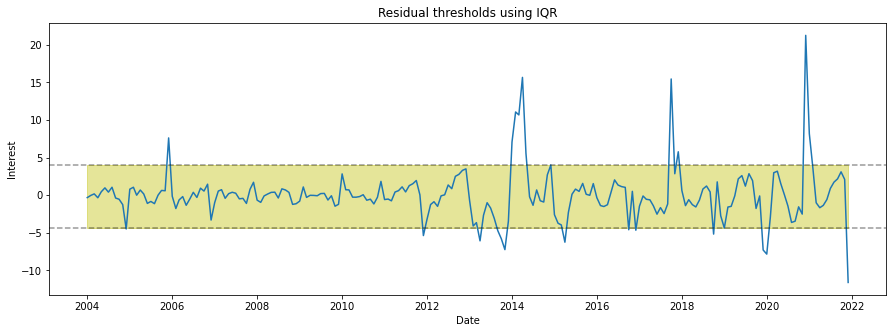

In [81]:
plt.figure(figsize=(15, 5))
plt.plot(fit.resid)

plt.axhline(low, color="k", ls="--", alpha=0.4)
plt.axhline(up, color="k", ls="--", alpha=0.4)
plt.fill_between(x=(data.index[0], data.index[-1]), y1=low, y2=up, color="y", alpha=0.4)
plt.xlabel("Date")
plt.ylabel("Interest")
plt.title("Residual thresholds using IQR");

From the plot we can see that there are many anomalies according to the rule based on IQR. To avoid false positives we can make the normal value interval a bit larger with a common rule of mean - 3 * std and mean + 3 * std (this is not result fishing).

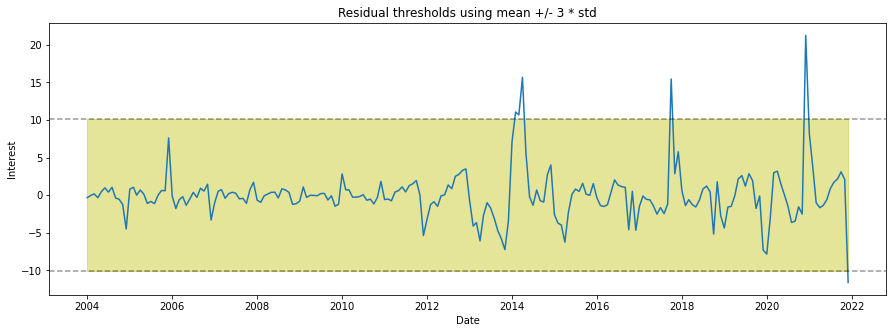

In [82]:
lower = mean_res - 3 * std_res
upper = mean_res + 3 * std_res

plt.figure(figsize=(15, 5))
plt.plot(fit.resid)

plt.axhline(lower, color="k", ls="--", alpha=0.4)
plt.axhline(upper, color="k", ls="--", alpha=0.4)
plt.fill_between(x=(data.index[0], data.index[-1]), y1=lower, y2=upper, color="y", alpha=0.4)
plt.xlabel("Date")
plt.ylabel("Interest")
plt.title("Residual thresholds using mean +/- 3 * std");


As we are not interested in the data of 2021 (drop is because not enough data), we can ignore the last drop. From the last graph we can notice 3 anomalies appearing in 2014, 2017 and 2020.

In [83]:
rule = (fit.resid < lower) | (fit.resid > upper)
data_points = data[rule]

Then we can plot the original data with the anomaly data points.

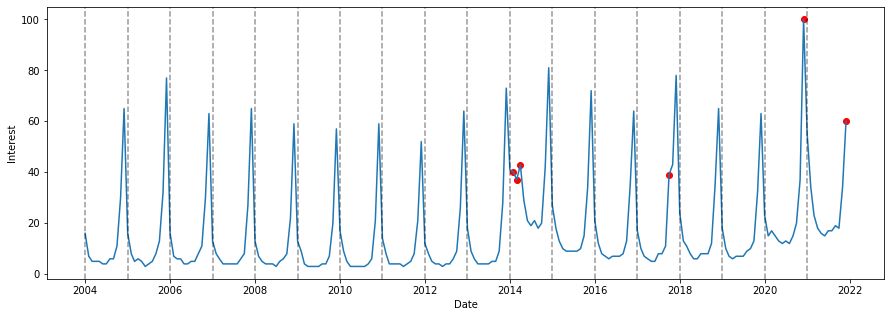

In [87]:
plt.figure(figsize=(15, 5))
plt.plot(data);
for year in data.index.year.unique():
    plt.axvline(datetime(year, 1, 1), color="k", ls="--", alpha=0.4)
plt.scatter(x=data_points.index, y=data_points, color="r")
plt.xlabel("Date")
plt.ylabel("Interest");

From the plot we can see the data points that correspond to the anomalies. The anomaly detection algorithm seems to agree with our own eye (which is surprisingly good at detecting anomalies). Finally, let's see which months correspond to the anomalies (ignoring the last one). 

In [100]:
for i, anomaly in enumerate(data_points.index[:-1]):
    print(f"Anomaly {i}: {anomaly}")

Anomaly 0: 2014-02-01 00:00:00
Anomaly 1: 2014-03-01 00:00:00
Anomaly 2: 2014-04-01 00:00:00
Anomaly 3: 2017-10-01 00:00:00
Anomaly 4: 2020-12-01 00:00:00


Last we can check what caused these anomalies. After a Google search one can find out that a famous movie by Disney, Frozen, was released in theaters during the Christmas season of 2013 and it had a hit song called "Do you want to build a snowman?". This could be the reason for the unusual interest of "snowman" during the winter and earky spring of 2014. In the fall of 2017 a film called "The Snowman" was released which could have caused the other anomaly. Finally, in the Christmas of 2020 there had been just released a Disney short film called "Once Upon a Snowman" which could have caused that higher than normal Christmas peak. Or it might be that people where just enjoying Christmas more than ever. Who knows.